In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import technical_analysis.backtest_kz as bt
from technical_analysis.indicators import Indicators 
from data_pipelines.data_manipulation import DataManipulation
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = 'ignore', category = pd.errors.PerformanceWarning)
%matplotlib inline

SYMBOL = 'BTC-USD'
SYMBOL_NAME = 'Bitcoin'
SYMBOL_CUT = 'btc'
scale = 1
range_list = [5,6,7,8,10,15,20]
range_list = [i*scale for i in range_list]
period = '2mo'
interval = '1h'
start_date = ''
end_data = ''
source = 'yahoo'

data = DataManipulation(SYMBOL, source, range_list, period=period, interval=interval, scale=scale, prefix_path='..', saved_to_csv=False)
df_price = data.df.copy()

In [2]:
tr_sh = bt.bt_threshold(df_price, 'rsi_10', 70, 30)
tr_sh.head()

,entry_time,exit_time,entry_price,exit_price,entry_ind,exit_ind,pnl_percent,pnl_cash
0,2022-10-02 10:00:00+00:00,2022-10-03 17:00:00+00:00,19110.0195,19545.3984,20.1080,71.4662,0.0228,1021.7828
1,2022-10-06 22:00:00+00:00,2022-10-14 01:00:00+00:00,19918.6484,19885.3594,29.9356,78.6952,-0.0017,1019.0897
2,2022-10-15 08:00:00+00:00,2022-10-16 19:00:00+00:00,19076.6289,19321.5195,28.6757,78.5806,0.0128,1030.9078
3,2022-10-18 18:00:00+00:00,2022-10-23 17:00:00+00:00,19227.2227,19433.4121,28.2012,85.8080,0.0107,1040.6008
4,2022-10-27 22:00:00+00:00,2022-10-28 16:00:00+00:00,20304.1719,20724.9805,29.4183,73.8670,0.0207,1060.2854


In [3]:
ext_df = data.extract_features()

In [4]:
import pandas as pd
from twitter.twitter_collection import TwitterCollection
from twitter.tweet_sentiment_analyzer import TweetSentimentAnalyzer

client_twitter = TwitterCollection()
df_btc_tweets = client_twitter.get_tweets_df(SYMBOL_NAME, pathdf=f'../data/tweets_data/{SYMBOL_CUT}/', filedf=f'{SYMBOL_CUT}_tweets.csv')

tsa = TweetSentimentAnalyzer(df_btc_tweets)
df = tsa.cleaning_tweet_data(df_btc_tweets)
df = tsa.preprocessing_tweet_datetime(df)
df = tsa.get_sentiment_scores(df)
tsa.add_datetime_to_col(df)
df_result = tsa.get_sent_with_mean_interval(df, interval='1h')
ext_df = tsa.concat_ohlc_compound_score(ext_df, df_result)

Python-dotenv could not parse statement starting at line 11
[nltk_data] Downloading package stopwords to /home/kozan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Authentication Successfull


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

In [6]:
X = ext_df.copy()
X.reset_index(inplace=True)
X.drop(columns=['Datetime', 'feature_label'], axis=1, inplace=True)
Y = ext_df.feature_label.copy()
Y = Y.reset_index()
Y.drop(columns=['Datetime'], axis=1, inplace=True)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=46)

In [8]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

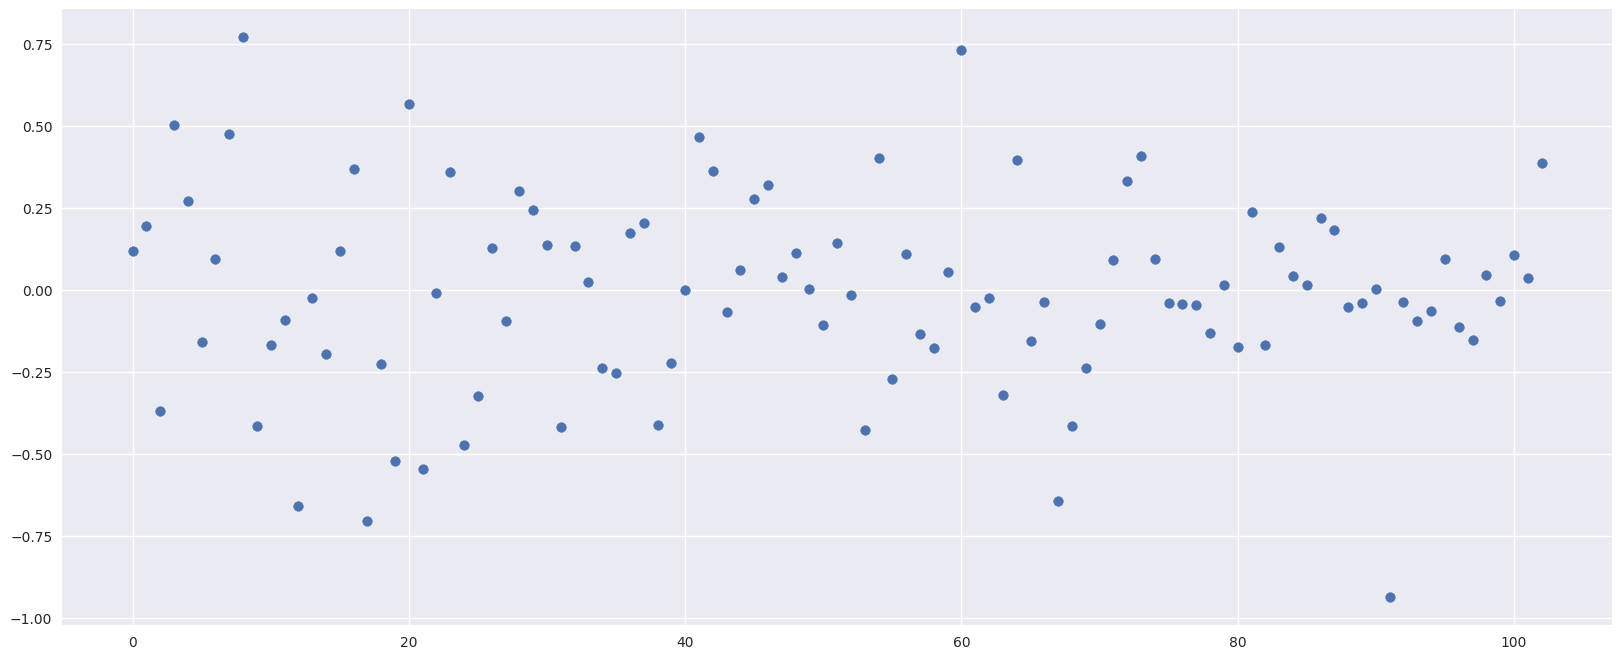

In [9]:
import matplotlib.pyplot as plt
import numpy as np
weigths = model.coef_
fig, ax = plt.subplots(1,1, figsize=(20,8))
plt.scatter(np.arange(0,len(np.column_stack(weigths).ravel())), np.column_stack(weigths).ravel())

In [10]:
np.column_stack(weigths).ravel().size

103

In [11]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

In [12]:
model = Sequential(
    [               
        tf.keras.Input(shape=(X_train.shape[1],)),
        Dense(units=128, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=32, activation='relu'),
        Dense(units=16, activation='relu'),
        Dense(units=1, activation='sigmoid')
    ], name = "my_model" 
)   

2022-11-25 23:19:49.555652: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-25 23:19:49.621764: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-25 23:19:49.621835: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-25 23:19:49.623598: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [13]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               13312     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 24,193
Trainable params: 24,193
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.001),
)

model.fit(
    X_train, y_train,
    epochs=40
)

Epoch 1/40
34/34 [==============================] - 1s 5ms/step - loss: 0.7051
Epoch 2/40
34/34 [==============================] - 0s 5ms/step - loss: 0.6911
Epoch 3/40
34/34 [==============================] - 0s 5ms/step - loss: 0.6897
Epoch 4/40
34/34 [==============================] - 0s 5ms/step - loss: 0.6928
Epoch 5/40
34/34 [==============================] - 0s 5ms/step - loss: 0.6925
Epoch 6/40
34/34 [==============================] - 0s 4ms/step - loss: 0.6837
Epoch 7/40
34/34 [==============================] - 0s 4ms/step - loss: 0.6802
Epoch 8/40
34/34 [==============================] - 0s 4ms/step - loss: 0.6764
Epoch 9/40
34/34 [==============================] - 0s 4ms/step - loss: 0.6741
Epoch 10/40
34/34 [==============================] - 0s 4ms/step - loss: 0.6704
Epoch 11/40
34/34 [==============================] - 0s 4ms/step - loss: 0.6608
Epoch 12/40
34/34 [==============================] - 0s 5ms/step - loss: 0.6540
Epoch 13/40
34/34 [==============================

In [15]:
pred = model.predict(X_test)
pred = (pred >= 0.5).astype(int)
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)
print(f'Confusion Matrix: {confusion_matrix(y_test, pred)}')
print(f'Accuracy Score {accuracy_score(y_test, pred)}')

9/9 [==============================] - 0s 2ms/step
Evaluate on test data
3/3 [==============================] - 0s 4ms/step - loss: 1.4023
test loss, test acc: 1.402265191078186
Confusion Matrix: [[79 66]
 [55 70]]
Accuracy Score 0.5518518518518518


In [16]:
pd.DataFrame(pred).value_counts()

1    136
0    134
dtype: int64

In [17]:
# CALCULATE KZ_INDEX/SCORE
ext_df['kz_score'] = ext_df.sum(axis = 1)

Text(0.5, 1.0, 'KZ Index')

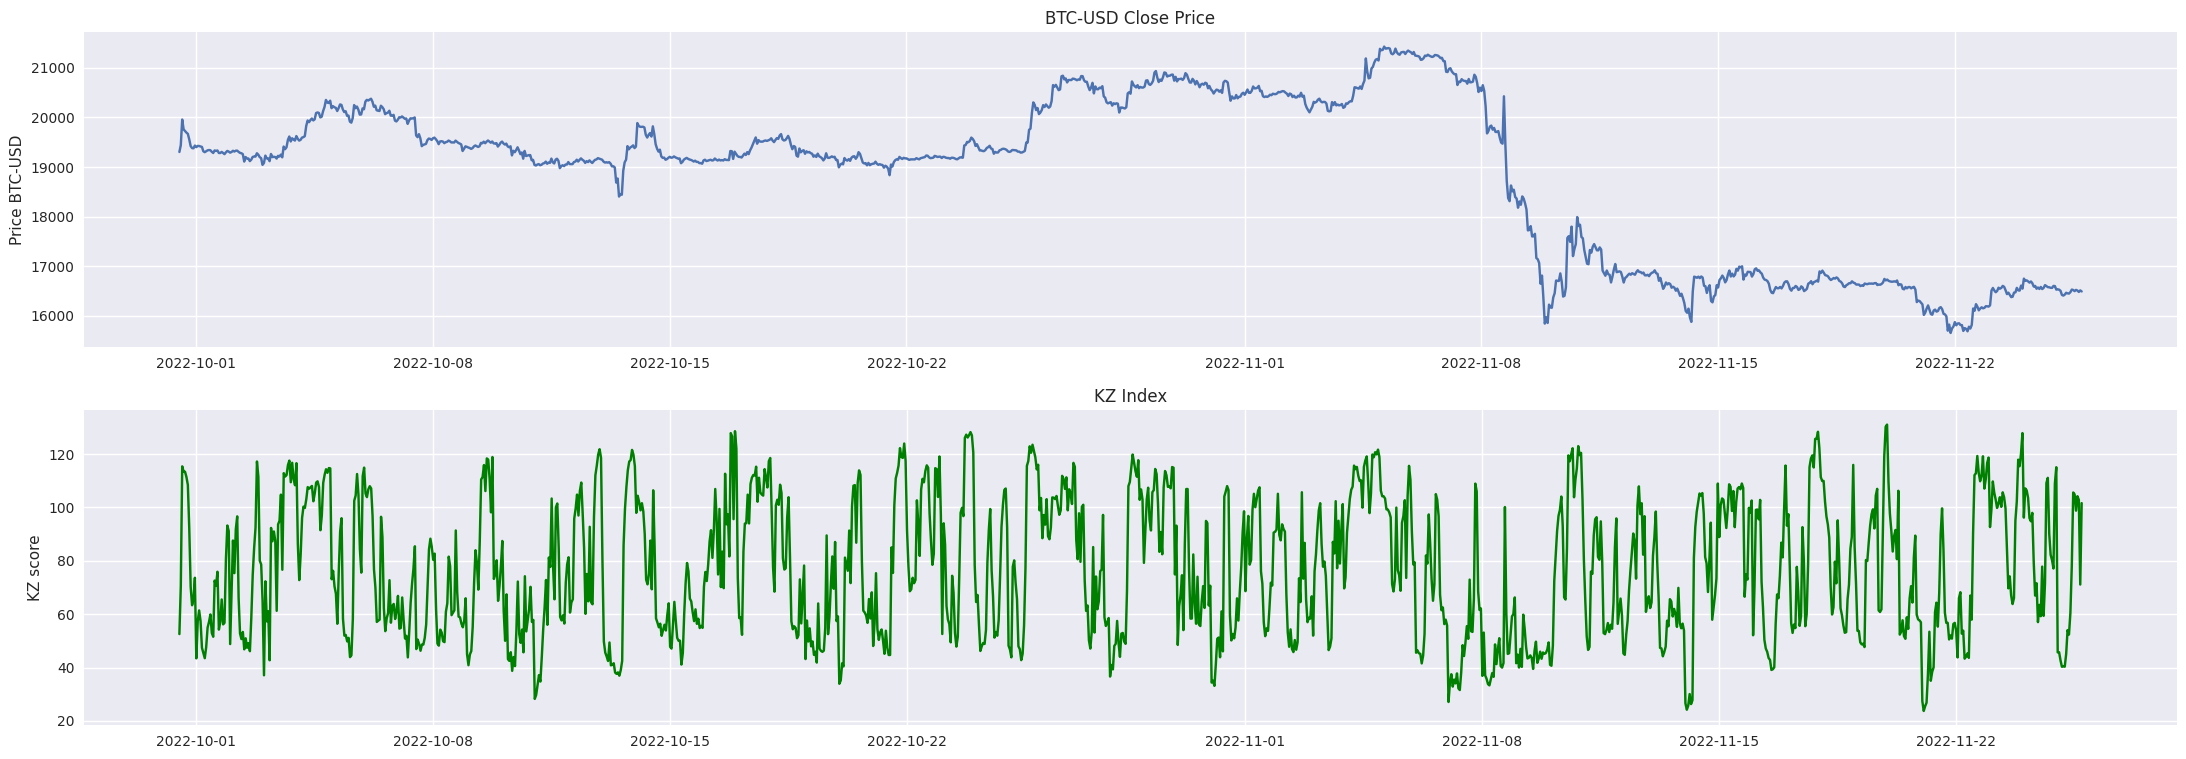

In [18]:
kz = ext_df.kz_score
close = df_price.close

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(27,9))
ax1.plot(close)
ax1.set_ylabel(f'Price {data.symbol}')
ax1.set_title(f'{data.symbol} Close Price')

ax2.plot(kz, color='green')
ax2.set_ylabel('KZ score')
ax2.set_title('KZ Index')

Text(0, 0.5, 'Sentiment Score')

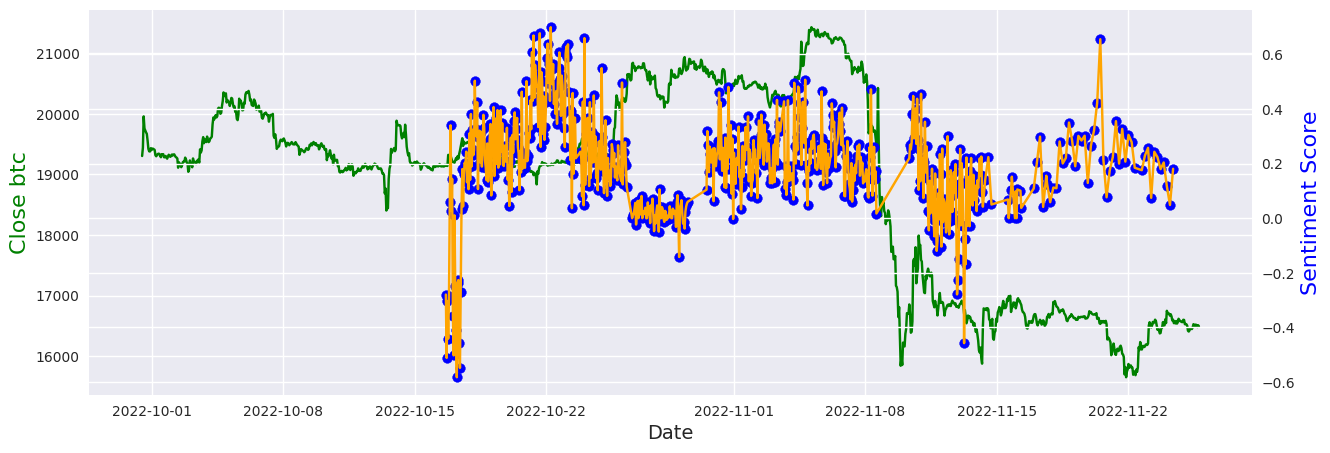

In [19]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df_price.index, df_price.close, color='green')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel(f'Close {SYMBOL_CUT}', color='green', fontsize=16)

ax2 = ax.twinx()
ax2.scatter(df_result.index, df_result.compound_total, color='blue')
ax2.plot(df_result.index, df_result.compound_total, color='orange')
ax2.set_ylabel('Sentiment Score', color='blue', fontsize=16)

In [30]:
df_price['kz_score'] = ext_df.kz_score
tr_sh = bt.bt_threshold(df_price, 'kz_score', 100, 25)
tr_sh.head()

,entry_time,exit_time,entry_price,exit_price,entry_ind,exit_ind,pnl_percent,pnl_cash
0,2022-11-14 01:00:00+00:00,2022-11-14 09:00:00+00:00,16096.6426,16765.7148,24.1758,101.8358,0.0416,1040.5660
1,2022-11-21 01:00:00+00:00,2022-11-22 13:00:00+00:00,16228.9355,16146.8799,23.7114,112.1203,-0.0051,1034.4693
